In [1]:
# ================
# Libraries
# ================
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.stats import skew, kurtosis
from scipy.fft import fft2
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score


In [2]:
# ================
# Feature Extraction Functions
# ================

def calculate_snr(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    image = cv2.resize(image, (128, 128))
    signal = np.mean(image)
    noise = np.std(image)
    return float('inf') if noise == 0 else 20 * np.log10(signal / noise)

def extract_features_from_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None
    image = cv2.resize(image, (512, 512))
    features = []
    features.append(np.mean(image) / (np.std(image) + 1e-5))
    features.append(cv2.Laplacian(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), cv2.CV_64F).var())
    features.append(np.sum(cv2.Canny(image, 100, 200) > 0) / (512 * 512))
    for i in range(3):
        channel = image[:, :, i].flatten()
        features.append(skew(channel))
        features.append(kurtosis(channel))
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    features.append(np.var(hsv[:, :, 1].flatten()))
    features.append(np.var(hsv[:, :, 0].flatten()))
    f = np.abs(fft2(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)))
    features.append(np.sum(f[30:, 30:]) / np.sum(f))
    return features

def build_features_dataframe_threadpool(image_folder, max_workers=8):
    image_names = os.listdir(image_folder)
    features_list = []

    def extract_single(img_name):
        return extract_features_from_image(os.path.join(image_folder, img_name))

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(extract_single, img_name) for img_name in tqdm(image_names, position=0, leave=True)]
        for future in tqdm(as_completed(futures), total=len(futures), desc="Collecting Results", position=0, leave=True):
            features_list.append(future.result())

    columns = ['SNR', 'LaplacianVar', 'EdgeDensity',
               'BlueSkew', 'BlueKurtosis', 'GreenSkew', 'GreenKurtosis',
               'RedSkew', 'RedKurtosis', 'SatVariance', 'HueVariance', 'HighFreqEnergy']
    df = pd.DataFrame(features_list, columns=columns)
    df['ImageName'] = image_names
    return df

In [4]:
# ================
# Load Dataset and Extract Features
# ================

train_labels = pd.read_csv('/kaggle/input/ai-vs-human-generated-dataset/train.csv')
test_labels = pd.read_csv('/kaggle/input/ai-vs-human-generated-dataset/test.csv')
train_labels['file_name'] = train_labels['file_name'].apply(lambda x: os.path.basename(x))
test_labels['id'] = test_labels['id'].apply(lambda x: os.path.basename(x))

train_images_path = '/kaggle/input/ai-vs-human-generated-dataset/train_data'
test_images_path = '/kaggle/input/ai-vs-human-generated-dataset/test_data_v2'

print("⚡ Extracting Train Features...")
train_features = build_features_dataframe_threadpool(train_images_path)

print("⚡ Extracting Test Features...")
test_features = build_features_dataframe_threadpool(test_images_path)

train_df = pd.merge(train_labels, train_features, left_on='file_name', right_on='ImageName')
test_df = pd.merge(test_labels, test_features, left_on='id', right_on='ImageName')
train_df.drop(columns=['ImageName'], inplace=True)
test_df.drop(columns=['ImageName'], inplace=True)

train_df.to_csv('/kaggle/working/train_features_updated.csv', index=False)
test_df.to_csv('/kaggle/working/test_features_updated.csv', index=False)

print("✅ Train and Test feature CSV files saved!")

⚡ Extracting Train Features...


100%|██████████| 79950/79950 [00:02<00:00, 33928.92it/s]


⚡ Extracting Test Features...


100%|██████████| 5540/5540 [00:00<00:00, 47550.09it/s]


✅ Train and Test feature CSV files saved!


In [5]:
print(train_df['label'].value_counts(normalize=True))

label
1    0.5
0    0.5
Name: proportion, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

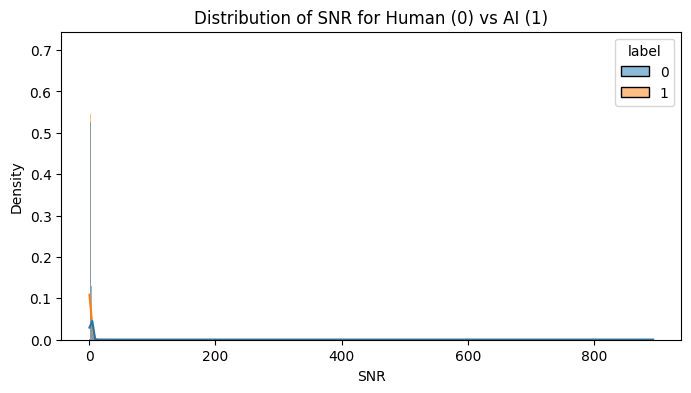

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

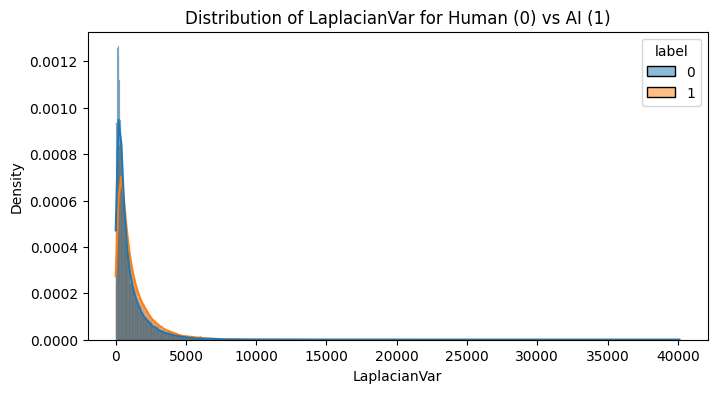

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

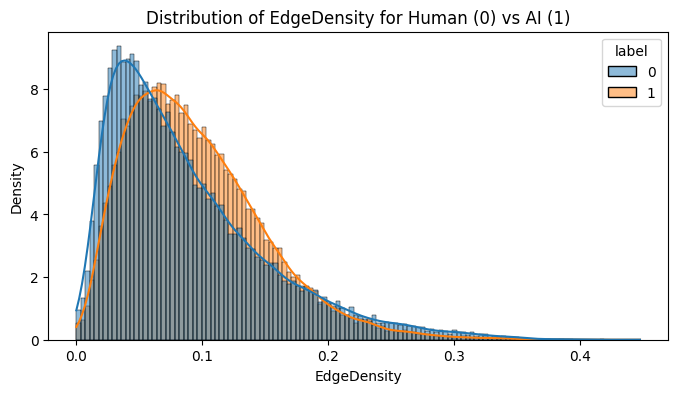

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

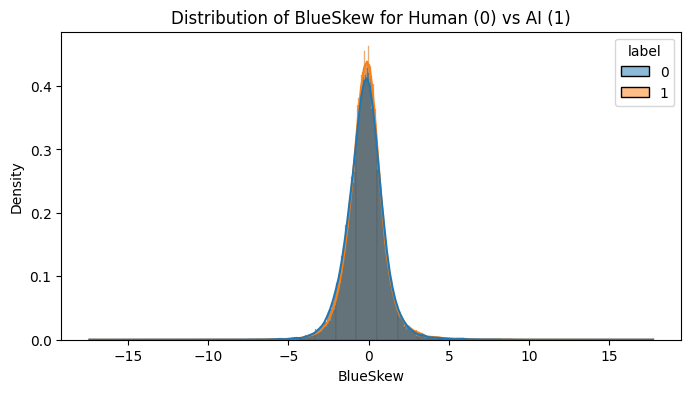

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

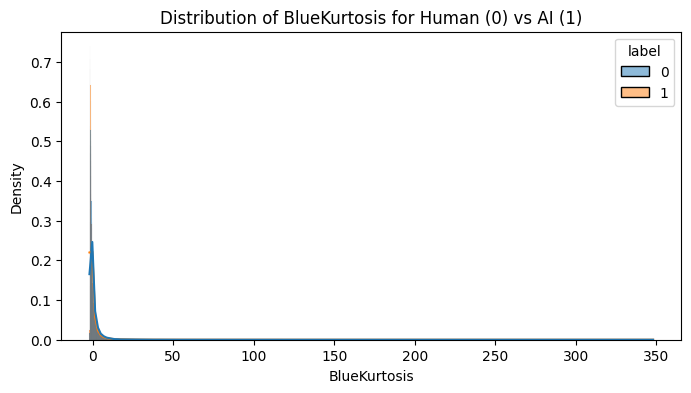

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

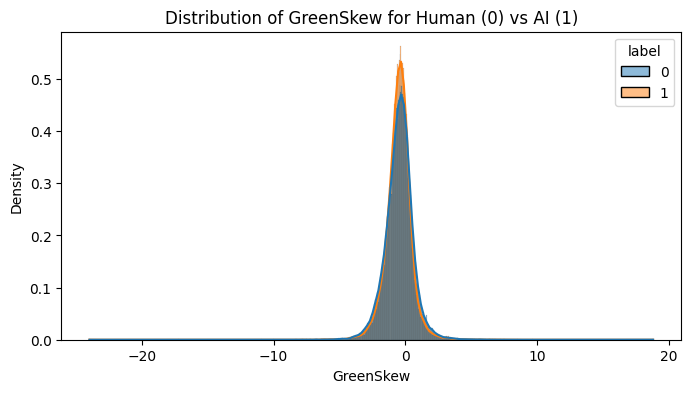

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

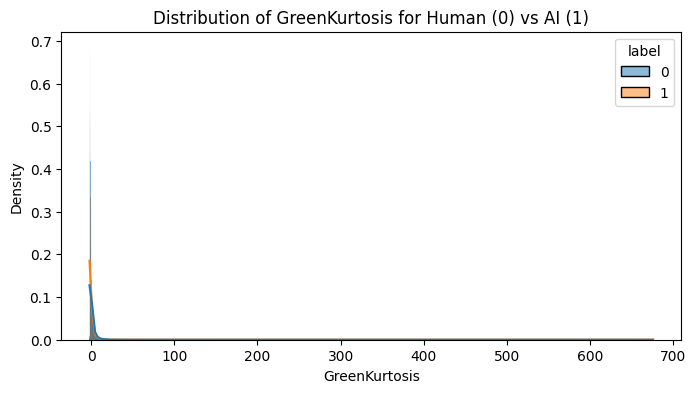

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

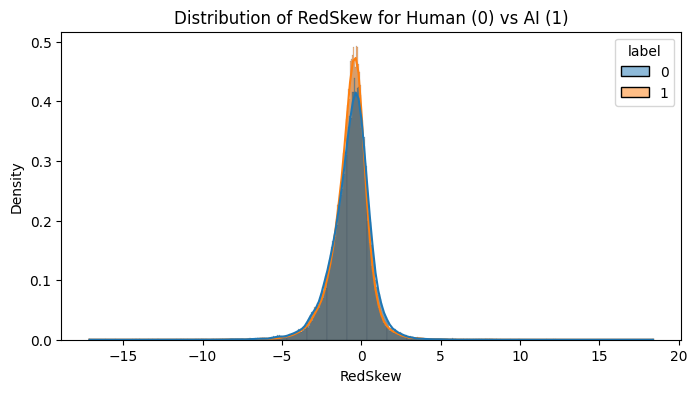

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

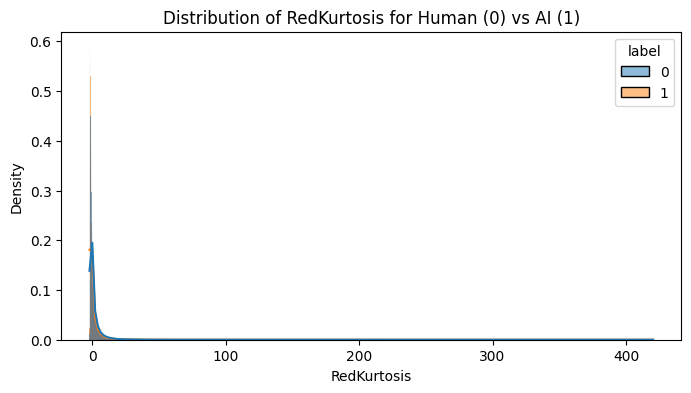

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

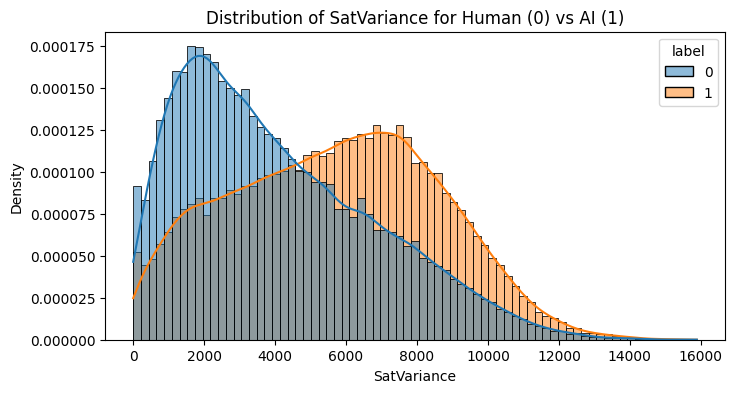

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

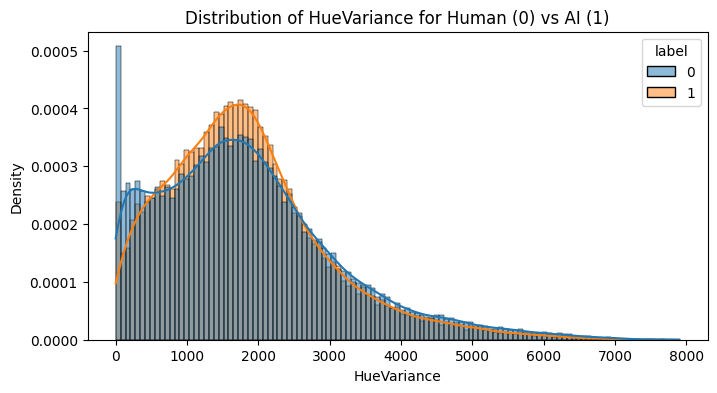

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

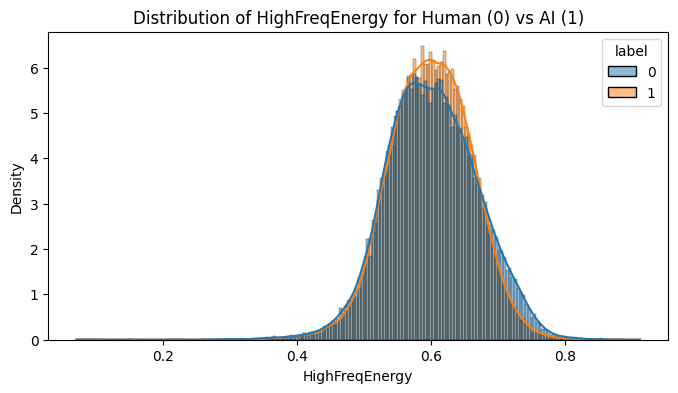

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

features = ['SNR', 'LaplacianVar', 'EdgeDensity', 
            'BlueSkew', 'BlueKurtosis', 
            'GreenSkew', 'GreenKurtosis', 
            'RedSkew', 'RedKurtosis', 
            'SatVariance', 'HueVariance', 'HighFreqEnergy']

for feat in features:
    plt.figure(figsize=(8,4))
    sns.histplot(data=train_df, x=feat, hue='label', kde=True, stat='density', common_norm=False)
    plt.title(f'Distribution of {feat} for Human (0) vs AI (1)')
    plt.show()


In [9]:
#================================#
#Udpating the SNR values formula
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed

def calculate_snr(image_path):
    """
    Calculate the Signal-to-Noise Ratio (SNR) of an image efficiently.

    Args:
        image_path (str): Path to the image file.

    Returns:
        float: SNR value in dB, or None if file is not found.
    """
    if not os.path.exists(image_path):
        return None  # Skip missing files

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale directly
    if image is None:
        return None

    # Resize for faster computation (comment out if full-size is needed)
    image = cv2.resize(image, (128, 128))

    signal = np.mean(image)
    noise = np.std(image)

    return float('inf') if noise == 0 else 20 * np.log10(signal / noise)

# Wrapper to parallelize
def calculate_snr_for_list(image_list, image_folder, n_jobs=-1):
    image_paths = [os.path.join(image_folder, img_name) for img_name in image_list]
    snr_values = Parallel(n_jobs=n_jobs)(
        delayed(calculate_snr)(img_path) for img_path in tqdm(image_paths)
    )
    return snr_values

# === Update SNR for train_df ===
train_image_folder = '/kaggle/input/ai-vs-human-generated-dataset/train_data'
print("⚡ Calculating SNR for train images...")

new_train_snr = calculate_snr_for_list(train_df['file_name'].tolist(), train_image_folder)
train_df['SNR'] = new_train_snr

print("✅ Updated SNR in train_df")

# === Update SNR for test_df ===
test_image_folder = '/kaggle/input/ai-vs-human-generated-dataset/test_data_v2'
print("⚡ Calculating SNR for test images...")

new_test_snr = calculate_snr_for_list(test_df['id'].tolist(), test_image_folder)
test_df['SNR'] = new_test_snr

print("✅ Updated SNR in test_df")

# === Save Updated Files ===
train_df.to_csv('/kaggle/working/train_features_updated_SNR.csv', index=False)
test_df.to_csv('/kaggle/working/test_features_updated_SNR.csv', index=False)

print("✅ Saved updated train and test feature CSVs!")

⚡ Calculating SNR for train images...



100%|██████████| 79950/79950 [02:55<00:00, 455.25it/s]


✅ Updated SNR in train_df
⚡ Calculating SNR for test images...



100%|██████████| 5540/5540 [00:51<00:00, 107.97it/s]


✅ Updated SNR in test_df
✅ Saved updated train and test feature CSVs!


In [11]:
# ================
#  Optimize SNR Threshold
# ================

def optimize_snr_threshold(df, metric='f1'):
    best_score = -1
    best_thresh = None
    thresholds = np.linspace(1.0, 5.0, 400)
    for thresh in thresholds:
        preds = (df['SNR'] < thresh).astype(int)
        if metric == 'f1':
            score = f1_score(df['label'], preds)
        if score > best_score:
            best_score = score
            best_thresh = thresh
    return best_thresh, best_score

best_snr_thresh, best_snr_score = optimize_snr_threshold(train_df, metric='f1')
print(f"🚀 Best SNR Threshold: {best_snr_thresh:.4f}")
print(f"✅ Best F1 Score achieved: {best_snr_score:.5f}")

snr_preds = (test_df['SNR'] < best_snr_thresh).astype(int)

🚀 Best SNR Threshold: 5.0000
✅ Best F1 Score achieved: 0.48317


[0]	validation_0-auc:0.70239


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-auc:0.74225
[100]	validation_0-auc:0.74351
[150]	validation_0-auc:0.74476
[200]	validation_0-auc:0.74642
[250]	validation_0-auc:0.74766
[300]	validation_0-auc:0.74913
[350]	validation_0-auc:0.75029
[400]	validation_0-auc:0.75135
[450]	validation_0-auc:0.75215
[500]	validation_0-auc:0.75295
[550]	validation_0-auc:0.75378
[600]	validation_0-auc:0.75447
[650]	validation_0-auc:0.75508
[700]	validation_0-auc:0.75576
[750]	validation_0-auc:0.75628
[800]	validation_0-auc:0.75676
[850]	validation_0-auc:0.75733
[900]	validation_0-auc:0.75776
[950]	validation_0-auc:0.75818
[1000]	validation_0-auc:0.75861
[1050]	validation_0-auc:0.75896
[1100]	validation_0-auc:0.75934
[1150]	validation_0-auc:0.75959
[1200]	validation_0-auc:0.75987
[1250]	validation_0-auc:0.76008
[1300]	validation_0-auc:0.76025
[1350]	validation_0-auc:0.76043
[1400]	validation_0-auc:0.76062
[1450]	validation_0-auc:0.76082
[1499]	validation_0-auc:0.76100


 26%|██▋       | 20999/79950 [09:28<26:37, 36.91it/s] 

✅ Validation AUC after training: 0.76100


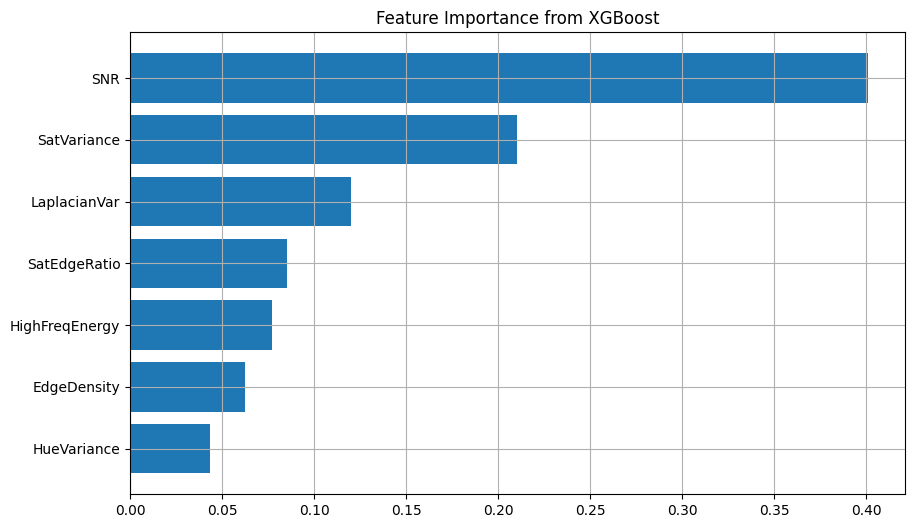

In [13]:
# ================
# Train XGBoost Model (using only strong features)
# ================

features_to_use = [
    'SNR', 'LaplacianVar', 'EdgeDensity',
    'SatVariance', 'HueVariance', 'HighFreqEnergy'
]

X = train_df[features_to_use].copy()
X_test = test_df[features_to_use].copy()
y = train_df['label'].astype(int)

X['SatEdgeRatio'] = X['SatVariance'] / (X['EdgeDensity'] + 1e-5)
X_test['SatEdgeRatio'] = X_test['SatVariance'] / (X_test['EdgeDensity'] + 1e-5)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model = xgb.XGBClassifier(
    n_estimators=1500,
    learning_rate=0.005,
    max_depth=5,
    subsample=0.7,
    colsample_bytree=0.7,
    gamma=0.1,
    reg_alpha=0.5,
    reg_lambda=1.0,
    random_state=42,
    use_label_encoder=False,
    eval_metric='auc',
    tree_method='hist'
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=50,
    verbose=50
)

val_preds = model.predict_proba(X_val)[:,1]
val_auc = roc_auc_score(y_val, val_preds)
print(f"✅ Validation AUC after training: {val_auc:.5f}")

# Feature Importance
importances = model.feature_importances_
features = X_train.columns
sorted_idx = np.argsort(importances)

plt.figure(figsize=(10,6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(np.arange(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.title('Feature Importance from XGBoost')
plt.grid(True)
plt.show()


In [14]:
# ================
# Optimize Blend Weights + Final Threshold
# ================
val_snr_preds = (X_val['SNR'] < best_snr_thresh).astype(int)

best_weight = 0
best_blend_score = 0
blend_weights = np.linspace(0, 1, 101)

for w in blend_weights:
    blended_val_preds = (w * val_preds) + ((1 - w) * val_snr_preds)
    blended_val_labels = (blended_val_preds > 0.5).astype(int)
    score = f1_score(y_val, blended_val_labels)
    if score > best_blend_score:
        best_blend_score = score
        best_weight = w

print(f"✅ Best Blend: XGB {best_weight:.2f}, SNR {1-best_weight:.2f}")

# Fine-tune final threshold
def find_best_final_threshold(preds, y_true, metric='f1'):
    best_score = -1
    best_thresh = 0.5
    thresholds = np.linspace(0.1, 0.9, 400)
    for thresh in thresholds:
        preds_binary = (preds > thresh).astype(int)
        if metric == 'f1':
            score = f1_score(y_true, preds_binary)
        if score > best_score:
            best_score = score
            best_thresh = thresh
    return best_thresh, best_score

final_blended_val_preds = (best_weight * val_preds) + ((1-best_weight) * val_snr_preds)

best_final_thresh, best_final_score = find_best_final_threshold(final_blended_val_preds, y_val)
print(f"🚀 Best Final Threshold: {best_final_thresh:.4f}")
print(f"✅ Best Fine-tuned F1: {best_final_score:.5f}")

✅ Best Blend: XGB 1.00, SNR 0.00
🚀 Best Final Threshold: 0.3667
✅ Best Fine-tuned F1: 0.71632


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

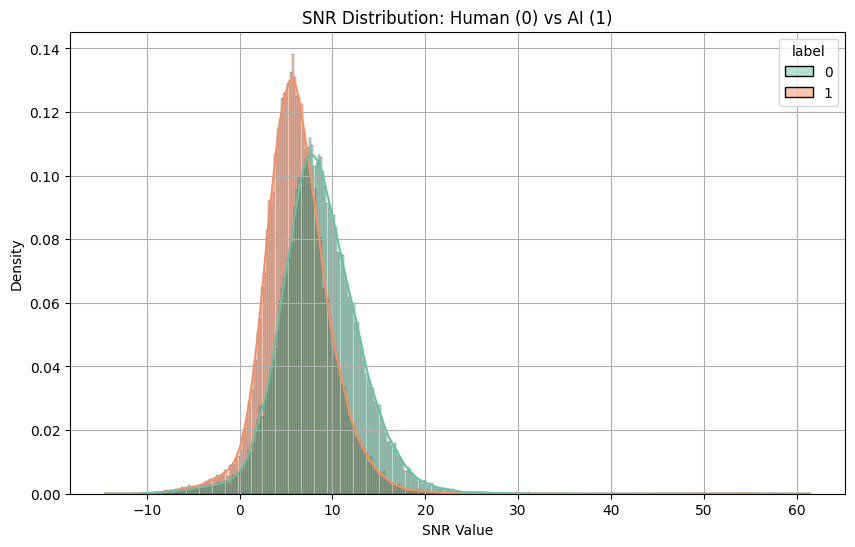

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot SNR distribution
plt.figure(figsize=(10,6))
sns.histplot(data=train_df, x='SNR', hue='label', kde=True, stat='density', common_norm=False, palette='Set2')
plt.title('SNR Distribution: Human (0) vs AI (1)')
plt.xlabel('SNR Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()


In [19]:
# ================
# Exploratory Data Analysis (EDA)
# ================

print(" SNR Statistics by Class")
print(train_df.groupby('label')['SNR'].agg(['mean', 'median', 'std', 'min', 'max', 'count']))


 SNR Statistics by Class
           mean    median       std        min        max  count
label                                                           
0      8.603475  8.391502  4.259577 -14.464372  35.041840  39975
1      6.184908  5.953422  3.749586 -11.232669  61.414305  39975


In [17]:
# ================
# Create Final Submission
# ================

print("⚡ Creating Final Submission...")

# Predict on Test Set
test_preds = model.predict_proba(X_test)[:,1]
blended_test_preds = (best_weight * test_preds) + ((1 - best_weight) * snr_preds)

final_labels = (blended_test_preds > best_final_thresh).astype(int)

submission = pd.DataFrame({
    'id': test_df['id'],
    'label': final_labels
})

submission['id'] = submission['id'].apply(lambda x: f'test_data_v2/{x}')
submission.to_csv('/kaggle/working/final_submission_finetuned_NEW.csv', index=False)

print("🎯 Final finetuned Submission File Created Successfully!")


⚡ Creating Final Submission...
🎯 Final finetuned Submission File Created Successfully!
